# Imports 

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import datetime
import itertools
import os
from IPython.display import clear_output

In [2]:
import re, string, unicodedata
import nltk
import nltk
import contractions
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords,wordnet
from nltk.stem import LancasterStemmer, WordNetLemmatizer 


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import Callback

import tensorflow as tf
import gensim

from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import cohen_kappa_score

# Tokenizing preprocessing functions; ripped from https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html

In [16]:
def strip_html(text):
    """remove html artifacts"""
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    """remove square brackets around things"""
    return re.sub('\[[^]]*\]', '', text)

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words, unless word is entirely uppercase"""
    new_words = []
    for word in words:
        if word != word.upper():
            new_word = word.lower()
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words, unless it is ! or ?"""
    new_words = []
    for word in words:
        if (word != '!') and (word != '?'):
            new_word = re.sub(r'[^\w\s]', '', word)
        else:
            new_word = word
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words, except 'no', 'not' """
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)                
                
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def preprocess_review(text):
    """Apply some subset of the preprocessing steps"""
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = replace_contractions(text)

    words = word_tokenize(text)
    words = to_lowercase(words)
    words = remove_non_ascii(words)
    words = lemmatize_verbs(words)
    words = remove_punctuation(words)
    return words

def get_month(date):
    """returns month from date"""
    return date.split(' ')[0]

def get_year(date):
    """returns month from date"""
    return date.split(' ')[-1]

def sentiment_from_rating(rating):
    """ maps 0-10 rating to Positive (1), Neutral (0), or Negative (-1)"""
    if rating > 6:
        return 1
    elif rating > 4:
        return 0
    else:
        return -1
      
def get_synonyms(w):
    synonyms = []
    for syn in wordnet.synsets(w):
        for lm in syn.lemmas():
            synonyms.append(lm.name())
    return np.unique(synonyms)

def num_positive_words(review):
    key_words = np.concatenate([get_synonyms('good'),get_synonyms('happy'),get_synonyms('great'),\
                              get_synonyms('satisfied'),get_synonyms('effective'),get_synonyms('normal')])
    return sum([Counter(review)[w] for w in lemmatize_verbs(key_words)])

def num_negative_words(review):
    key_words = np.concatenate([get_synonyms('bad'),get_synonyms('worse'),get_synonyms('horrible'),\
                              get_synonyms('terrible'),get_synonyms('unsatisfied'),get_synonyms('ineffective'),\
                             get_synonyms('weird'),get_synonyms('abnormal')])
    return sum([Counter(review)[w] for w in lemmatize_verbs(key_words)]) 

# Preprocess by applying tokenizer, isolating year/month from dates, adding sentiment column, and various pieces of metadata about each review. Also maps words to numerical values to use as input for classifiers

In [19]:
train_data = pd.read_csv('../data/raw/drugsComTrain_raw.tsv',sep='\t')
test_data = pd.read_csv('../data/raw/drugsComTest_raw.tsv',sep='\t')

train_data.columns = ['identifier']+list(train_data.columns[1:])
train_data['year'] = train_data['date'].apply(get_year)
train_data['month'] = train_data['date'].apply(get_month)

test_data.columns = ['identifier']+list(test_data.columns[1:])
test_data['year'] = test_data['date'].apply(get_year)
test_data['month'] = test_data['date'].apply(get_month)

cleaned_reviews_train = train_data['review'].apply(preprocess_review)
cleaned_reviews_test = test_data['review'].apply(preprocess_review)

train_data['cleaned_review'] = cleaned_reviews_train
test_data['cleaned_review'] = cleaned_reviews_test

train_data['sentiment'] = train_data['rating'].apply(sentiment_from_rating)
test_data['sentiment'] = test_data['rating'].apply(sentiment_from_rating)

all_words = list(itertools.chain.from_iterable(train_data['cleaned_review'])) \
          + list(itertools.chain.from_iterable(test_data['cleaned_review']))
sorted_words = Counter(all_words).most_common()
sorted_words = [i[0] for i in sorted_words]
word2idx = dict(zip(sorted_words,range(len(sorted_words))))

def indexer(words):
    """
    returns indices of words in list of tokenized words based on how common they are
    pads rest of vector with zeros so all vectors are the same length 
    """
    return [word2idx[word] for word in words]

train_data['indexed_tokens'] = train_data['cleaned_review'].apply(indexer)
test_data['indexed_tokens'] = test_data['cleaned_review'].apply(indexer)

train_data['num_words']=train_data['indexed_tokens'].apply(lambda x: len(x))
test_data['num_words']=test_data['indexed_tokens'].apply(lambda x: len(x))

train_data['num_exclamations'] = train_data['cleaned_review'].apply(lambda x: Counter(x)['!'])
test_data['num_exclamations'] = test_data['cleaned_review'].apply(lambda x: Counter(x)['!'])

train_data['num_poses'] = train_data['cleaned_review'].apply(num_positive_words)
test_data['num_poses'] = test_data['cleaned_review'].apply(num_positive_words)

train_data['num_negs'] = train_data['cleaned_review'].apply(num_negative_words)
test_data['num_negs'] = test_data['cleaned_review'].apply(num_negative_words)

train_data.to_csv('../data/processed/alec_train.csv')
test_data.to_csv('../data/processed/alec_test.csv')

# Load cleaned data if it exists. Takes a few minutes

In [20]:
train_data = pd.read_csv('../data/processed/alec_train.csv')
train_data = train_data[train_data.columns[1:]]
train_data['cleaned_review'] = train_data['cleaned_review'].apply(eval)
train_data['indexed_tokens'] = train_data['indexed_tokens'].apply(eval)

test_data = pd.read_csv('../data/processed/alec_test.csv')
test_data = test_data[test_data.columns[1:]]
test_data['cleaned_review'] = test_data['cleaned_review'].apply(eval)
test_data['indexed_tokens'] = test_data['indexed_tokens'].apply(eval)

# Example review with preprocessing

In [23]:
print("Raw review: ",train_data['review'][16])
print()
print("Cleaned, tokenized review: ",train_data['cleaned_review'][16])
print()
print("Numerical representation of review: ",train_data['indexed_tokens'][16])

Raw review:  "This drug worked very well for me and cleared up my UTI in a matter of 48hrs, although I was on a 7 day course of 2x200mg/daily. Unfortunately once the tablets finished the infection returned so needed a 2nd course. I&#039;m currently taking a low dose at evening to keep the infection at bay while the specialists do some tests.  I normally get every side effect going and dread taking new medication in any form especially after an horrific experience with Ciorofloxacin but the only side effect I experienced with this was itchy ankles and feet on day two but that didn&#039;t last into third day so I would class this as a minor side effect and insignificant. Good luck."

Cleaned, tokenized review:  ['this', 'drug', 'work', 'very', 'well', 'for', 'me', 'and', 'clear', 'up', 'my', 'UTI', 'in', 'a', 'matter', 'of', '48hrs', 'although', 'I', 'be', 'on', 'a', '7', 'day', 'course', 'of', '2x200mgdaily', 'unfortunately', 'once', 'the', 'tablets', 'finish', 'the', 'infection', 'retu

# Define Callback subclass to dynamically plot the loss and accuracy to check for over/underfitting during LSTM training

In [24]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="training loss")
        ax1.plot(self.x, self.val_losses, label="validation loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="training accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot_learning = PlotLearning()

# Train LSTM network to predict sentiment from review text

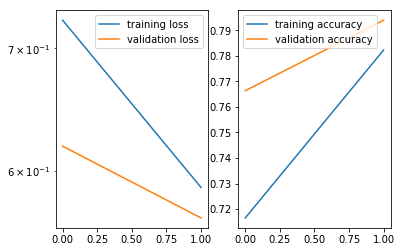

161297/161297 [==============================] - 251s 2ms/sample - loss: 0.5877 - acc: 0.7823 - val_loss: 0.5655 - val_acc: 0.7940
Epoch 3/100
  2300/161297 [..............................] - ETA: 3:53 - loss: 0.5248 - acc: 0.8183

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/aleckirkley/anaconda/envs/drugreviews/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-f94f1baa2881>", line 35, in <module>
    batch_size=batch_size,validation_data=(X_test_LSTM, y_test),callbacks=[plot_learning])#,es])
  File "/Users/aleckirkley/anaconda/envs/drugreviews/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 880, in fit
    validation_steps=validation_steps)
  File "/Users/aleckirkley/anaconda/envs/drugreviews/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_arrays.py", line 329, in model_iteration
    batch_outs = f(ins_batch)
  File "/Users/aleckirkley/anaconda/envs/drugreviews/lib/python3.7/site-packages/tensorflow/python/keras/backend.py", line 3076, in __call__
    run_metadata=self.run_metadata)
  File "/Users/aleckirkley/anaconda/envs/drugreviews/lib/pyth

KeyboardInterrupt: 

In [25]:
tokenized_vec_length = 150 
embedding_vector_length_LSTM = 16

X_train_LSTM,X_test_LSTM = pad_sequences(train_data['indexed_tokens'], maxlen=tokenized_vec_length, truncating='post'), \
                 pad_sequences(test_data['indexed_tokens'], maxlen=tokenized_vec_length, truncating='post')
y_train,y_test = np.array(train_data['sentiment'])+1., np.array(test_data['sentiment'])+1.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

n_words = np.max(np.concatenate([X_train_LSTM,X_test_LSTM]).flatten())+1
LSTM_model = Sequential()
LSTM_model.add(Embedding(n_words, embedding_vector_length_LSTM, input_length=tokenized_vec_length))
LSTM_model.add(LSTM(3,dropout=0.4, recurrent_dropout=0.2))
LSTM_model.add(Dense(3, activation='softmax'))
n_epochs,batch_size = 100,100

SAVE_LSTM_MODEL = False

if SAVE_LSTM_MODEL:
    np.random.seed(7)
    checkpoint_path_LSTM = "/content/drive/My Drive/MDST/text_models/LSTM_model_drugs.ckpt"
    checkpoint_dir_LSTM = os.path.dirname(checkpoint_path_LSTM)
    cp_callback_LSTM = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_LSTM,
                                                   save_weights_only=True,
                                                   verbose=1)
    LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_LSTM = LSTM_model.fit(X_train_LSTM, y_train,
            epochs=n_epochs,
            batch_size=batch_size,validation_data=(X_test_LSTM, y_test),callbacks=[plot_learning,cp_callback_LSTM])#,es])
else:
    np.random.seed(7)
    LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_LSTM = LSTM_model.fit(X_train_LSTM, y_train,
            epochs=n_epochs,
            batch_size=batch_size,validation_data=(X_test_LSTM, y_test),callbacks=[plot_learning])#,es])


# Train metadata classifier to predict sentiment

In [26]:
train_metadata = train_data[['drugName','condition','usefulCount','year','month','num_words']].copy()
test_metadata = test_data[['drugName','condition','usefulCount','year','month','num_words']].copy()
all_metadata = pd.concat([train_metadata,test_metadata]).reset_index()
usefulCount_cutoffs = [np.percentile(all_metadata['usefulCount'],k) for k in np.arange(0,100,10)]
num_words_cutoffs = [np.percentile(all_metadata['num_words'],k) for k in np.arange(0,100,10)]
all_metadata['usefulCount'] = np.digitize(all_metadata['usefulCount'],usefulCount_cutoffs)-1
all_metadata['num_words'] = np.digitize(all_metadata['num_words'],num_words_cutoffs)-1
all_metadata['drugName'] = pd.factorize(all_metadata['drugName'])[0]
all_metadata['condition'] = pd.factorize(all_metadata['condition'])[0]+1
all_metadata['year'] = pd.factorize(all_metadata['year'])[0]
all_metadata['month'] = pd.factorize(all_metadata['month'])[0]

In [27]:
all_reviews = pd.concat([train_data['cleaned_review'],test_data['cleaned_review']]).reset_index()
X_train_meta,X_test_meta = all_metadata[:len(train_metadata)].as_matrix()[:,1:],\
                           all_metadata[len(train_metadata):].as_matrix()[:,1:]

/Users/aleckirkley/anaconda/envs/drugreviews/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/aleckirkley/anaconda/envs/drugreviews/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
embedding_vector_length_meta = 20

n_cats = np.max(np.concatenate([X_train_meta,X_test_meta]).flatten())+1
meta_model = Sequential()
meta_model.add(Embedding(n_cats, embedding_vector_length_meta, input_length=len(X_train_meta[0])))
meta_model.add(LSTM(1))
meta_model.add(Dense(3, activation='softmax'))

SAVE_META_MODEL = False

if SAVE_META_MODEL:
  np.random.seed(7)
  checkpoint_path_meta = "/content/drive/My Drive/MDST/meta_models/meta_model_drugs.ckpt"
  checkpoint_dir_meta = os.path.dirname(checkpoint_path_meta)
  cp_callback_meta = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_meta,
                                                   save_weights_only=True,
                                                   verbose=1)
  meta_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history_meta = meta_model.fit(X_train_meta, y_train,
            epochs=1000,
            batch_size=1000,
            validation_data=(X_test_meta, y_test),callbacks=[plot_learning,cp_callback_meta])#,es])
  
else:
  np.random.seed(7)
  meta_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history_meta = meta_model.fit(X_train_meta, y_train,
            epochs=1000,
            batch_size=1000,
            validation_data=(X_test_meta, y_test),callbacks=[plot_learning])#,es])
  

NameError: ignored

# Load trained models

In [ ]:
#Review text model
# tokenized_vec_length = 150 
# embedding_vector_length_LSTM = 16

# X_train_LSTM,X_test_LSTM = pad_sequences(train_data['indexed_tokens'], maxlen=tokenized_vec_length, truncating='post'), \
#                  pad_sequences(test_data['indexed_tokens'], maxlen=tokenized_vec_length, truncating='post')
# y_train,y_test = np.array(train_data['sentiment'])+1., np.array(test_data['sentiment'])+1.
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

# n_words = np.max(np.concatenate([X_train_LSTM,X_test_LSTM]).flatten())+1
# LSTM_model = Sequential()
# LSTM_model.add(Embedding(n_words, embedding_vector_length_LSTM, input_length=tokenized_vec_length))
# LSTM_model.add(LSTM(10,dropout=0.2, recurrent_dropout=0.2))
# LSTM_model.add(Dense(3, activation='softmax'))

# checkpoint_path_LSTM = "text_models/LSTM_model_drugs.ckpt"
# checkpoint_dir_LSTM = os.path.dirname(checkpoint_path_LSTM)
# cp_callback_LSTM = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_LSTM,
#                                                  save_weights_only=True,
#                                                  verbose=1)

# LSTM_model.load_weights(checkpoint_path_LSTM)


#metadata model
# embedding_vector_length_meta = 20

# n_cats = np.max(np.concatenate([X_train_meta,X_test_meta]).flatten())+1
# meta_model = Sequential()
# meta_model.add(Embedding(n_cats, embedding_vector_length_meta, input_length=len(X_train_meta[0])))
# meta_model.add(LSTM(1))
# meta_model.add(Dense(3, activation='softmax'))

# checkpoint_path_meta = "meta_models/meta_model_drugs.ckpt"
# checkpoint_dir_meta = os.path.dirname(checkpoint_path_meta)
# cp_callback_meta = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_meta,
#                                                  save_weights_only=True,
#                                                  verbose=1)

meta_model.load_weights(checkpoint_path_meta)

# Evaluate ensemble model accuracy, NMI, and Kappa score

In [ ]:
LSTM_class_probs = LSTM_model.predict(X_test_LSTM)
metadata_class_probs = meta_model.predict(X_test_meta)
r = 1. #fraction of sentiment guess weight allocated to LSTM model versus metadata model
predictions = np.array([np.argmax(LSTM_class_probs[i]*r+metadata_class_probs[i]*(1.-r))\
                         for i in range(LSTM_class_probs.shape[0])])
true_labels = np.array([np.argmax(i) for i in y_test])

accuracy = accuracy_score(true_labels,predictions)
NMI = normalized_mutual_info_score(true_labels,predictions)
Kappa = cohen_kappa_score(true_labels,predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
